In [1]:
import crocoddyl
import mujoco
import mujoco.viewer
import mim_solvers
import numpy as np
import matplotlib.pyplot as plt
import hppfcl
import time
from os.path import dirname, join, abspath
np.set_printoptions(precision=4, linewidth=180)

import pin_utils, mpc_utils
from Kuka_utils import *
from Kuka_model import *
from Kuka_Mujoco_utils import *
from IRL_solver import IRL_Crocoddyl
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer

from mim_robots.pybullet.env import BulletEnvWithGround
from mim_robots.robot_loader import load_bullet_wrapper, load_mujoco_model, get_robot_list, load_pinocchio_wrapper
from mim_robots.robot_list import MiM_Robots
from numpy.linalg import norm, solve
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize
from scipy.optimize import Bounds


pybullet build time: Nov 28 2023 23:45:17


In [2]:
%run -i 'init.py'

In [3]:
obs_set = obstacle_set()
obs_set.add_obs(np.array([0.65, -0.05, 0.7]), l = 0.05, col_r = 0.15)
obs_set.add_obs(np.array([0.65, -0.15, 0.45]), l = 0.1, col_r = 0.15)
obs_set.add_obs(np.array([0.65, -0.25, 0.7]), l = 0.1, col_r = 0.15)
obs_num = obs_set.obs_num

In [4]:
# endeff frame translation goal
endeff_frame_id = pin_model.getFrameId("contact")
endeff_joint_id = pin_model.getJointId("contact")
# endeff_translation = pin_data.oMf[endeff_frame_id].translation.copy()
endeff_translation = np.array([0.4,  -0.5,  0.35])

In [5]:
w_run = {
    'translation': .5,
    'xReg': 0.1,
    'uReg': 0.0001
}

w_term = {
    'translation': 10,
    'xReg': 0.1
}

In [6]:
c=0
for _ in range(obs_set.obs_num): # Adding Obstacle weights
    w_run['collision'+str(c)] = 1000
    w_term['collision'+str(c)] = 1000
    c+=1

w_run = dict(sorted(w_run.items()))
w_term = dict(sorted(w_term.items()))

w_run, w_term = normalize_w(w_run, w_term)

In [7]:
dt = 1e-2
T = 150

solver = init_robot(robot_simulator, q0, v0, obs_set, endeff_translation, w_run, w_term, dt, T)

Keys_run = solver.problem.runningDatas[0].differential.costs.costs.todict().keys()
Keys_term = solver.problem.terminalData.differential.costs.costs.todict().keys()
nr_run = len(Keys_run); nr_term = len(Keys_term); nr = nr_run + nr_term

xs_init = [x0 for i in range(T+1)]
us_init = solver.problem.quasiStatic(xs_init[:-1])

/home/sarmad/machines-in-motion/my_git/IRL_Kuka/Kuka_utils.py:29: UserWarning: Deprecated member. Use Frame.parentJoint instead.
  m.frames[pin_model.getFrameId("universe")].parent,
/home/sarmad/machines-in-motion/my_git/IRL_Kuka/Kuka_utils.py:27: UserWarning: This function has been marked as deprecated and will be removed in a future release.
  obsObj = pin.GeometryObject("obstacle"+str(num_obs),


In [19]:
def get_single_feature(solver, xs, us, ind):
    keys_run = list(solver.problem.runningModels[0].differential.costs.costs.todict().keys())
    nr_run = len(keys_run)
    keys_term = list(solver.problem.terminalModel.differential.costs.costs.todict().keys())
    nr_term = len(keys_term)
    nr = nr_run + nr_term
    Phi = np.zeros(nr)
    x = xs[ind]
    u = us[ind]
    solver.problem.runningModels[ind].differential.actuation.calc(solver.problem.runningDatas[ind].differential.multibody.actuation, x, u)
    solver.problem.runningModels[ind].differential.actuation.calcDiff(solver.problem.runningDatas[ind].differential.multibody.actuation, x, u)
    for j, k in enumerate(keys_run):
        solver.problem.runningModels[ind].differential.costs.costs[k].cost.calc(solver.problem.runningDatas[ind].differential.costs.costs[k], x, u)
        solver.problem.runningModels[ind].differential.costs.costs[k].cost.calcDiff(solver.problem.runningDatas[ind].differential.costs.costs[k], x, u)
        Phi[j] = solver.problem.runningDatas[ind].differential.costs.costs[k].cost

    return Phi

def get_traj_features(solver, xs, us):
    keys_run = list(solver.problem.runningModels[0].differential.costs.costs.todict().keys())
    nr_run = len(keys_run)
    keys_term = list(solver.problem.terminalModel.differential.costs.costs.todict().keys())
    nr_term = len(keys_term)
    nr = nr_run + nr_term
    Phi = np.zeros(nr)
    Phi_set = []

    X = xs[-1]
    # solver.problem.terminalModel.differential.actuation.calc(solver.problem.terminalData.differential.multibody.actuation, X)
    # solver.problem.terminalModel.differential.actuation.calcDiff(solver.problem.terminalData.differential.multibody.actuation, X)
    for j, k in enumerate(keys_term):
        solver.problem.terminalModel.differential.costs.costs[k].cost.calc(solver.problem.terminalData.differential.costs.costs[k], X)
        solver.problem.terminalModel.differential.costs.costs[k].cost.calcDiff(solver.problem.terminalData.differential.costs.costs[k], X)
        Phi[j + nr_run] += solver.problem.terminalData.differential.costs.costs[k].cost
    Phi_set.append(Phi.copy())
        
    # Running Features
    for i in range(T-1,-1,-1):
        X = xs[i]; U = us[i]
        solver.problem.runningModels[i].differential.actuation.calc(solver.problem.runningDatas[i].differential.multibody.actuation, X, U)
        solver.problem.runningModels[i].differential.actuation.calcDiff(solver.problem.runningDatas[i].differential.multibody.actuation, X, U)
        for j, k in enumerate(keys_run):
            solver.problem.runningModels[i].differential.costs.costs[k].cost.calc(solver.problem.runningDatas[i].differential.costs.costs[k], X, U)
            solver.problem.runningModels[i].differential.costs.costs[k].cost.calcDiff(solver.problem.runningDatas[i].differential.costs.costs[k], X, U)
            Phi[j] += solver.problem.runningDatas[i].differential.costs.costs[k].cost
        Phi_set.append(Phi.copy())
    
    return Phi, Phi_set

In [9]:
print(xs_init[50])
print(us_init[50])
print(0.5*(np.sum(us_init[50]*us_init[50])))
G = pin.computeGeneralizedGravity(solver.problem.runningModels[50].state.pinocchio, solver.problem.runningDatas[50].differential.pinocchio, xs_init[50][:7])
R = solver.problem.runningDatas[50].differential.costs.costs['uReg'].residual.r
tau = solver.problem.runningDatas[50].differential.costs.costs['uReg'].shared.actuation.tau
u = solver.problem.runningDatas[50].differential.costs.costs['uReg'].shared.actuation.u
print('tau: ', tau)
print('Grav: ', G)
print('Residual: ', R)
print('U - Grav: ', tau - G)
r = u - G
print(0.5*R.dot(R))
print(0.5*r.dot(r))

[ 0.2  0.7  0.3 -1.1 -0.3  0.3  0.   0.   0.   0.   0.   0.   0.   0. ]
[-1.7764e-15 -5.7920e+01  3.4617e+00  2.4774e+01 -1.2829e+00 -3.5516e-01  0.0000e+00]
1991.1206552211158
tau:  [0. 0. 0. 0. 0. 0. 0.]
Grav:  [-1.7764e-15 -5.7920e+01  3.4617e+00  2.4774e+01 -1.2829e+00 -3.5516e-01  0.0000e+00]
Residual:  [0. 0. 0. 0. 0. 0. 0.]
U - Grav:  [ 1.7764e-15  5.7920e+01 -3.4617e+00 -2.4774e+01  1.2829e+00  3.5516e-01  0.0000e+00]
0.0
1991.1206552211158


In [15]:
get_single_feature(solver, xs_init, us_init, 50)

array([0.    , 0.    , 0.    , 0.3684, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

In [11]:
# # Solve 
update_solver_weights(solver, T, w_run, w_term)
solver.termination_tolerance = 1e-4
solver.with_callbacks = False
solver.solve(xs_init.copy(), us_init.copy(), 500)
xs_opt = solver.xs.copy()
us_opt = solver.us.copy()

In [12]:
# solver.problem.runningModels[50].differential.actuation.calc(solver.problem.runningDatas[50].differential.multibody.actuation, xs_init[50], us_init[50])
# solver.problem.runningModels[50].differential.actuation.calcDiff(solver.problem.runningDatas[50].differential.multibody.actuation, xs_init[50], us_init[50])

In [12]:
print(get_single_feature(solver, xs_init, us_init, 50))
print()
print(us_init[50])
G = pin.computeGeneralizedGravity(solver.problem.runningModels[50].state.pinocchio, solver.problem.runningDatas[50].differential.pinocchio, xs_init[50][:7])
R = solver.problem.runningDatas[50].differential.costs.costs['uReg'].residual.r
tau = solver.problem.runningDatas[50].differential.costs.costs['uReg'].shared.actuation.tau
u = solver.problem.runningDatas[50].differential.costs.costs['uReg'].shared.actuation.u
print('tau: ', tau)
print('Grav: ', G)
print('Residual: ', R)
print('U - Grav: ', tau - G)
r = u - G
print('True residual: ',  r)
print(0.5*R.dot(R))
print(0.5*r.dot(r))

[0.     0.     0.     0.3684 0.     0.     0.     0.     0.     0.     0.    ]

[-1.7764e-15 -5.7920e+01  3.4617e+00  2.4774e+01 -1.2829e+00 -3.5516e-01  0.0000e+00]
tau:  [-1.7764e-15 -5.7920e+01  3.4617e+00  2.4774e+01 -1.2829e+00 -3.5516e-01  0.0000e+00]
Grav:  [-1.7764e-15 -5.7920e+01  3.4617e+00  2.4774e+01 -1.2829e+00 -3.5516e-01  0.0000e+00]
Residual:  [0. 0. 0. 0. 0. 0. 0.]
U - Grav:  [0. 0. 0. 0. 0. 0. 0.]
True residual:  [ 1.7764e-15  5.7920e+01 -3.4617e+00 -2.4774e+01  1.2829e+00  3.5516e-01  0.0000e+00]
0.0
1991.1206552211158


In [16]:
print(get_single_feature(solver, xs_opt, us_opt, 50))

[1.7429e-06 0.0000e+00 0.0000e+00 1.2914e-01 2.3814e+01 1.8390e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]


In [17]:
print(get_single_feature(solver, xs_init, us_init, 149))

[0.     0.     0.     0.3684 0.     0.     0.     0.     0.     0.     0.    ]


In [20]:
p, ps = get_traj_features(solver, xs_opt, us_opt)

[2.2773e-05 9.6315e-05 2.0381e-05 1.5586e+01 5.4776e+03 2.4506e+02 0.0000e+00 0.0000e+00 0.0000e+00 2.8329e-04 6.3196e-01]
[2.2773e-05 9.6315e-05 2.0381e-05 1.5586e+01 5.4776e+03 2.4506e+02 0.0000e+00 0.0000e+00 0.0000e+00 2.8329e-04 6.3196e-01]


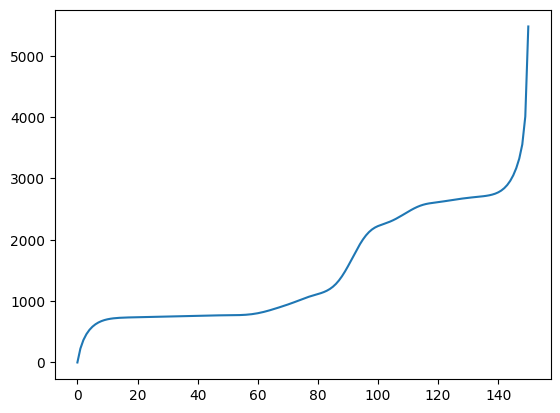

In [21]:
print(p)
print(ps[-1])
plt.plot(np.stack(ps)[:,4])

In [17]:
ps_ = []
for i in range(T-1,-1,-1):
    ps_.append(get_single_feature(solver, xs_opt, us_opt, i))

ps_ = np.stack(ps_)
print(p_)
print(ps_[-1])

NameError: name 'p_' is not defined

In [ ]:
print(ps[0])
print(p)


In [ ]:
n = 40
m = 30
# m = n
U = us_opt[m]; X = xs_opt[m]
solver.problem.runningModels[n].differential.costs.costs['uReg'].cost.calc(solver.problem.runningDatas[n].differential.costs.costs['uReg'], X, U)
solver.problem.runningModels[n].differential.costs.costs['uReg'].cost.calcDiff(solver.problem.runningDatas[n].differential.costs.costs['uReg'], X, U)
print(solver.problem.runningDatas[n].differential.costs.costs['uReg'].cost)
# print(U)
m = solver.problem.runningModels[n].state.pinocchio
d = solver.problem.runningDatas[n].differential.pinocchio
pin.forwardKinematics(m,d,X[:m.nq],X[m.nq:])
pin.framesForwardKinematics(m,d,X[:m.nq])
pin.updateFramePlacements(m,d)
pin.computeAllTerms(m,d,X[:m.nq],X[m.nq:])
pin.computeJointJacobians(m,d, X[:m.nq])
solver.problem.runningModels[n].differential.costs.costs['uReg'].cost.calc(solver.problem.runningDatas[n].differential.costs.costs['uReg'], X, U)
solver.problem.runningModels[n].differential.costs.costs['uReg'].cost.calcDiff(solver.problem.runningDatas[n].differential.costs.costs['uReg'], X, U)
print(solver.problem.runningDatas[n].differential.costs.costs['uReg'].cost)

In [ ]:
R = solver.problem.runningDatas[n].differential.costs.costs['uReg'].residual.r
print(R)
print(U)
C = solver.problem.runningDatas[n].differential.costs.costs['uReg'].cost
print(0.5*R.dot(R))
print(C)

In [ ]:
random = np.random.randint(0,T)
d = solver.problem.runningDatas[random].differential.multibody.pinocchio
m = solver.problem.runningModels[random].differential.state.pinocchio
# pin.computeAllTerms(m,d,X[:m.nq],X[m.nq:])
# pin.computeJointJacobians(m,d, X[:m.nq])
# G = pin.computeGeneralizedGravity(m,d,X[:m.nq])
# del(d); del(m)
l = 2
U = us_opt[l]; X = xs_opt[l]
G = pin.computeGeneralizedGravity(m,d,X[:m.nq])
solver.problem.runningModels[l].differential.costs.costs['uReg'].cost.calc(solver.problem.runningDatas[l].differential.costs.costs['uReg'], X, U)
solver.problem.runningModels[l].differential.costs.costs['uReg'].cost.calcDiff(solver.problem.runningDatas[l].differential.costs.costs['uReg'], X, U)
# print(solver.problem.runningDatas[0].differential.costs.costs['translation'].residual.shared.joint.tau)
R = solver.problem.runningDatas[l].differential.costs.costs['uReg'].residual.r
R1 = solver.problem.runningDatas[l].differential.costs.costs['uReg'].residual.shared.joint.tau
print('Gravity:', G)
print('Tau:')
print(R1)
print(U)
print('Residual:')
print(R)
print(U - G)


In [ ]:
solver.problem.runningModels[l].differential.

In [ ]:
solver.problem.runningModels[l].differential.costs.costs['uReg'].cost.calc()